### 1. Imports

In [2]:
import os
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.tree import plot_tree

### 2. Load Data

In [3]:
# Load the dataset
df = pd.read_csv('prepared_data.csv')

# Convert 'date' column to datetime and set as index
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df.set_index('date', inplace=True)

# Display the first few rows
df.head()

,symbol,streak_len,direction,occurrence,performance,vol,ma5_pos,ma200_pos,ma5_neg,ma200_neg,next_day_actual,bin_name
date,,,,,,,,,,,,
2025-02-27,TSLA,6,-1,19,-1,1,0,1,1,0,1,6 -1 -1 -1 1 0 1 1 0
2025-02-26,TSLA,5,-1,53,-1,1,0,1,1,0,-1,5 -1 -1 -1 1 0 1 1 0
2025-02-25,MSFT,3,-1,620,-1,-1,0,0,-1,1,1,3 -1 -1 -1 -1 0 0 -1 1
2025-02-25,TSLA,4,-1,103,-1,-1,0,1,1,0,-1,4 -1 -1 -1 -1 0 1 1 0
2025-02-24,TSLA,3,-1,230,-1,-1,0,1,-1,0,-1,3 -1 -1 -1 -1 0 1 -1 0


In [4]:
df['next_day_actual'].value_counts()

next_day_actual
 1    2742
-1    2479
 0     162
Name: count, dtype: int64

### 3. Preprocessing

In [5]:
# Remove rows where 'next_day_actual' is 0 (no change)
df = df[df['next_day_actual'] != 0]

# Convert -1 to 0 in 'next_day_actual'
df['next_day_actual'] = df['next_day_actual'].replace(-1, 0)

# Ensure 'streak_len' is integer and drop unnecessary columns
df['streak_len'] = df['streak_len'].astype(int)
df.drop(columns=['symbol', 'bin_name', 'occurrence'], inplace=True)

# Display unique values in 'next_day_actual'
df['next_day_actual'].unique()

array([1, 0])

In [6]:
df['next_day_actual'].unique()

array([1, 0])

In [7]:
df.dtypes

streak_len         int64
direction          int64
performance        int64
vol                int64
ma5_pos            int64
ma200_pos          int64
ma5_neg            int64
ma200_neg          int64
next_day_actual    int64
dtype: object

In [8]:
df.head()

,streak_len,direction,performance,vol,ma5_pos,ma200_pos,ma5_neg,ma200_neg,next_day_actual
date,,,,,,,,,
2025-02-27,6,-1,-1,1,0,1,1,0,1
2025-02-26,5,-1,-1,1,0,1,1,0,0
2025-02-25,3,-1,-1,-1,0,0,-1,1,1
2025-02-25,4,-1,-1,-1,0,1,1,0,0
2025-02-24,3,-1,-1,-1,0,1,-1,0,0


### 4. Exploratory Data Analysis (EDA)

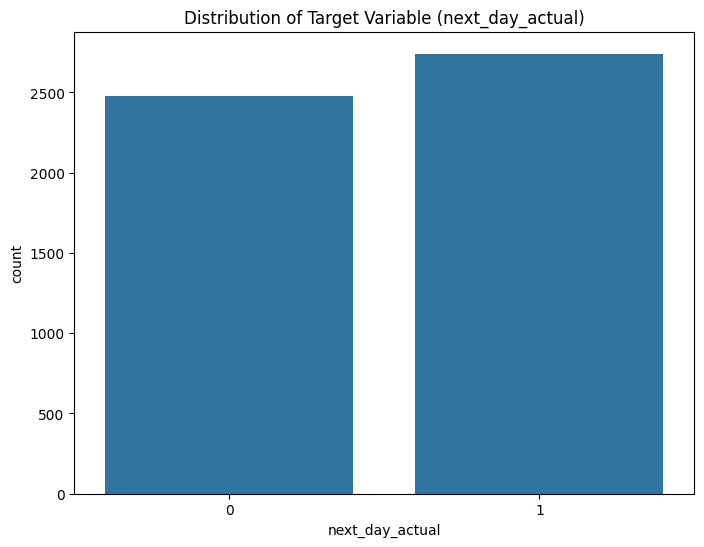

In [9]:
# Distribution of target variable
plt.figure(figsize=(8, 6))
sns.countplot(x='next_day_actual', data=df)
plt.title('Distribution of Target Variable (next_day_actual)')
plt.show()

**Correlation Heatmap:** visualizes the relationships between variables in the dataset. It uses colors to represent the strength and direction of correlations:
- **1**: Strong positive correlation (dark red).
- **-1**: Strong negative correlation (dark blue).
- **0**: No correlation (white).

This helps identify which features are strongly related and guides feature selection for modeling.

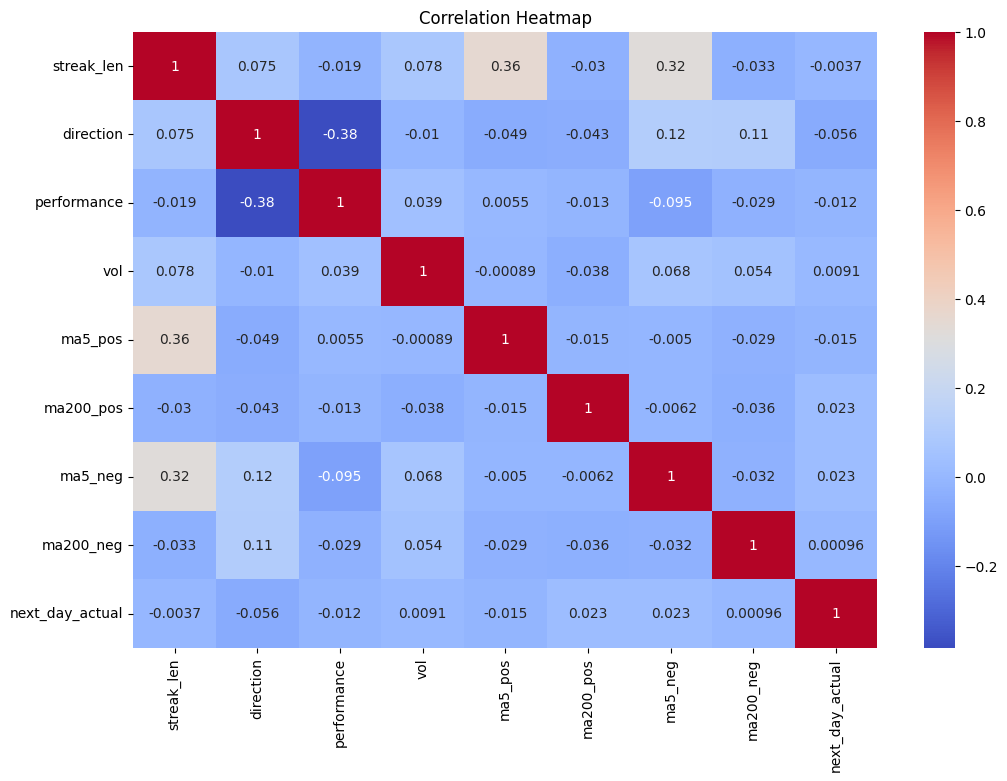

In [10]:
# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

### 5. Train-Test Split

In [11]:
# Split data into features (x) and target (y)
x = df.iloc[:, :-1]
y = df['next_day_actual']

# Split into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

### 6. One-Hot Encoding

In [12]:
cols = x.columns.to_list()
cols

['streak_len',
 'direction',
 'performance',
 'vol',
 'ma5_pos',
 'ma200_pos',
 'ma5_neg',
 'ma200_neg']

In [13]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore').fit(df[cols])
encoded_cols = list(encoder.get_feature_names_out(cols))

# Apply encoding to training and testing data
x_train[encoded_cols] = encoder.transform(x_train[cols])
x_test[encoded_cols] = encoder.transform(x_test[cols])

In [14]:
x_train.columns

Index(['streak_len', 'direction', 'performance', 'vol', 'ma5_pos', 'ma200_pos',
       'ma5_neg', 'ma200_neg', 'streak_len_3', 'streak_len_4', 'streak_len_5',
       'streak_len_6', 'streak_len_7', 'streak_len_8', 'streak_len_9',
       'streak_len_10', 'streak_len_11', 'streak_len_12', 'streak_len_13',
       'direction_-1', 'direction_0', 'direction_1', 'performance_-1',
       'performance_0', 'performance_1', 'vol_-1', 'vol_0', 'vol_1',
       'ma5_pos_-1', 'ma5_pos_0', 'ma5_pos_1', 'ma200_pos_-1', 'ma200_pos_0',
       'ma200_pos_1', 'ma5_neg_-1', 'ma5_neg_0', 'ma5_neg_1', 'ma200_neg_-1',
       'ma200_neg_0', 'ma200_neg_1'],
      dtype='object')

In [15]:
# Keep only encoded columns
x_train = x_train[encoded_cols]
x_test = x_test[encoded_cols]

In [16]:
x_train.shape

(4176, 32)

In [17]:
# Convert encoded columns and target to boolean
x_train = x_train.astype(bool)
x_test = x_test.astype(bool)
y_train = y_train.astype(bool)
y_test = y_test.astype(bool)

### 7. Random Forest Model Training

In [18]:
def find_optimal_hyperparameters(X, y):
    """
    Perform Grid Search to find the optimal hyperparameters for RandomForestClassifier.

    Parameters:
    X (pd.DataFrame or np.ndarray): Feature matrix.
    y (pd.Series or np.ndarray): Target vector.

    Returns:
    dict: Best hyperparameters.
    """
    # Define the parameter grid
    param_grid = {
        'n_estimators': [100, 200, 500],
        'max_depth': [10, 50, 100, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', None],
        'bootstrap': [True, False]
    }

    # Initialize the model
    rf = RandomForestClassifier(random_state=42)

    # Perform Grid Search with Cross-Validation
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                               cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
    
    # Fit the model
    grid_search.fit(X, y)

    # Return the best parameters
    return grid_search.best_params_

# Example usage:
# Assuming X_train and y_train are your feature matrix and target vector
# best_params = find_optimal_hyperparameters(X_train, y_train)
# print("Best Hyperparameters:", best_params)

In [19]:
# find_optimal_hyperparameters(x_train,y_train)

In [20]:
# Function to train or load model
def safe_train(model, model_name, X_train, y_train):
    model_path = f"{model_name}.pkl"
    if os.path.exists(model_path):
        print(f"✅ {model_name} already trained! Loading instead of training...")
        return joblib.load(model_path)
    else:
        print(f"🚀 Training {model_name}...")
        model.fit(X_train, y_train)
        joblib.dump(model, model_path)
        print(f"✅ {model_name} trained & saved!")
        return model

In [21]:
# Define Random Forest model with optimal hyperparameters
model = RandomForestClassifier(
    n_estimators=500,
    max_depth=10,
    max_features='sqrt',
    min_samples_split=10,
    min_samples_leaf=2,
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)

In [22]:
# Train the model
model = safe_train(model, "random_forest_model", x_train, y_train)

🚀 Training random_forest_model...
✅ random_forest_model trained & saved!


In [23]:
# Evaluate model performance
print("Training Accuracy:", model.score(x_train, y_train))
print("Test Accuracy:", model.score(x_test, y_test))

Training Accuracy: 0.5943486590038314
Test Accuracy: 0.5119617224880383


### 8. Model Evaluation

**Confusion Matrix:**
A confusion matrix is a table used to evaluate the performance of a classification model. It shows:
- **True Positives (TP)**: Correctly predicted positive cases.
- **True Negatives (TN)**: Correctly predicted negative cases.
- **False Positives (FP)**: Negative cases incorrectly predicted as positive.
- **False Negatives (FN)**: Positive cases incorrectly predicted as negative.

It helps visualize how well the model is performing and identify where it makes mistakes.

**Confusion Matrix (2D Array):**
In a confusion matrix `m`:

- **`m[0, 0]`**: True Negatives (TN) – Correctly predicted negatives.
- **`m[0, 1]`**: False Positives (FP) – Incorrectly predicted positives (Type I Error).
- **`m[1, 0]`**: False Negatives (FN) – Incorrectly predicted negatives (Type II Error).
- **`m[1, 1]`**: True Positives (TP) – Correctly predicted positives.

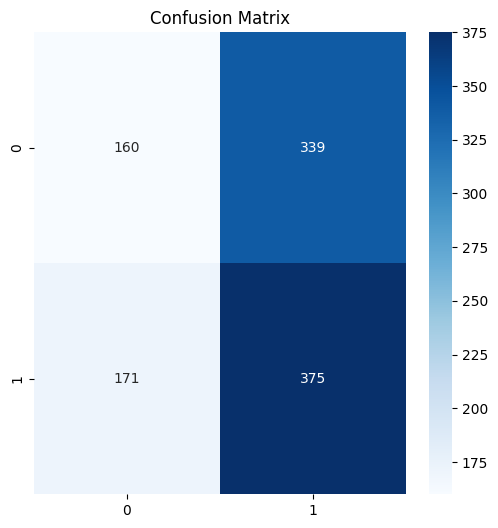

In [24]:
# Confusion Matrix
y_pred = model.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

### **Classification Report**
A classification report provides key metrics to evaluate a classification model:
- **Precision**: Percentage of correct positive predictions out of all positive predictions.
- **Recall**: Percentage of actual positives correctly predicted by the model.
- **F1-Score**: Harmonic mean of precision and recall (balances both metrics).
- **Support**: Number of actual occurrences of each class in the dataset.

These metrics help assess the model's accuracy and reliability for each class.

In [25]:
# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

       False       0.48      0.32      0.39       499
        True       0.53      0.69      0.60       546

    accuracy                           0.51      1045
   macro avg       0.50      0.50      0.49      1045
weighted avg       0.51      0.51      0.50      1045



**ROC Curve (Receiver Operating Characteristic Curve):**
The ROC Curve visualizes the performance of a binary classification model by plotting:
- **True Positive Rate (TPR)** (y-axis): The proportion of actual positives correctly predicted.
- **False Positive Rate (FPR)** (x-axis): The proportion of actual negatives incorrectly predicted as positives.

- **AUC-ROC Score**: The area under the ROC curve, ranging from 0 to 1:
  - **1**: Perfect classifier.
  - **0.5**: Random classifier.
  - **< 0.5**: Worse than random.

The ROC Curve helps evaluate how well the model distinguishes between the two classes at different classification thresholds.

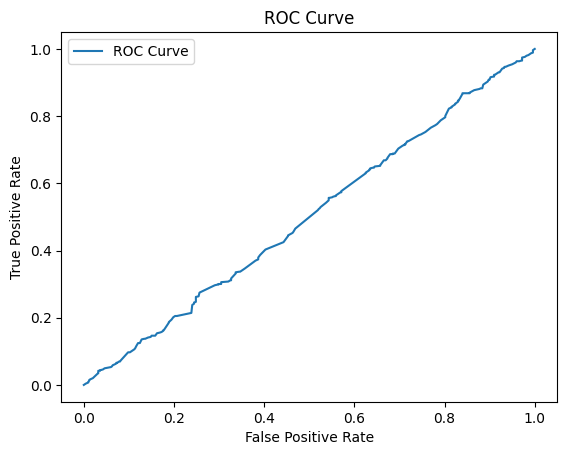

In [26]:
# ROC Curve
y_pred_proba = model.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [27]:
print("AUC-ROC Score:", roc_auc_score(y_test, y_pred_proba))

AUC-ROC Score: 0.5003395068525329


### 9. Feature Importance

In [28]:
# Feature Importance
importance_df = pd.DataFrame({
    'Feature': x_train.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)
importance_df

,Feature,Importance
17,vol_-1,0.067425
19,vol_1,0.066114
16,performance_1,0.065012
14,performance_-1,0.061486
1,streak_len_4,0.060863
0,streak_len_3,0.059101
2,streak_len_5,0.051923
25,ma200_pos_1,0.043698
31,ma200_neg_1,0.041154
23,ma200_pos_-1,0.040953


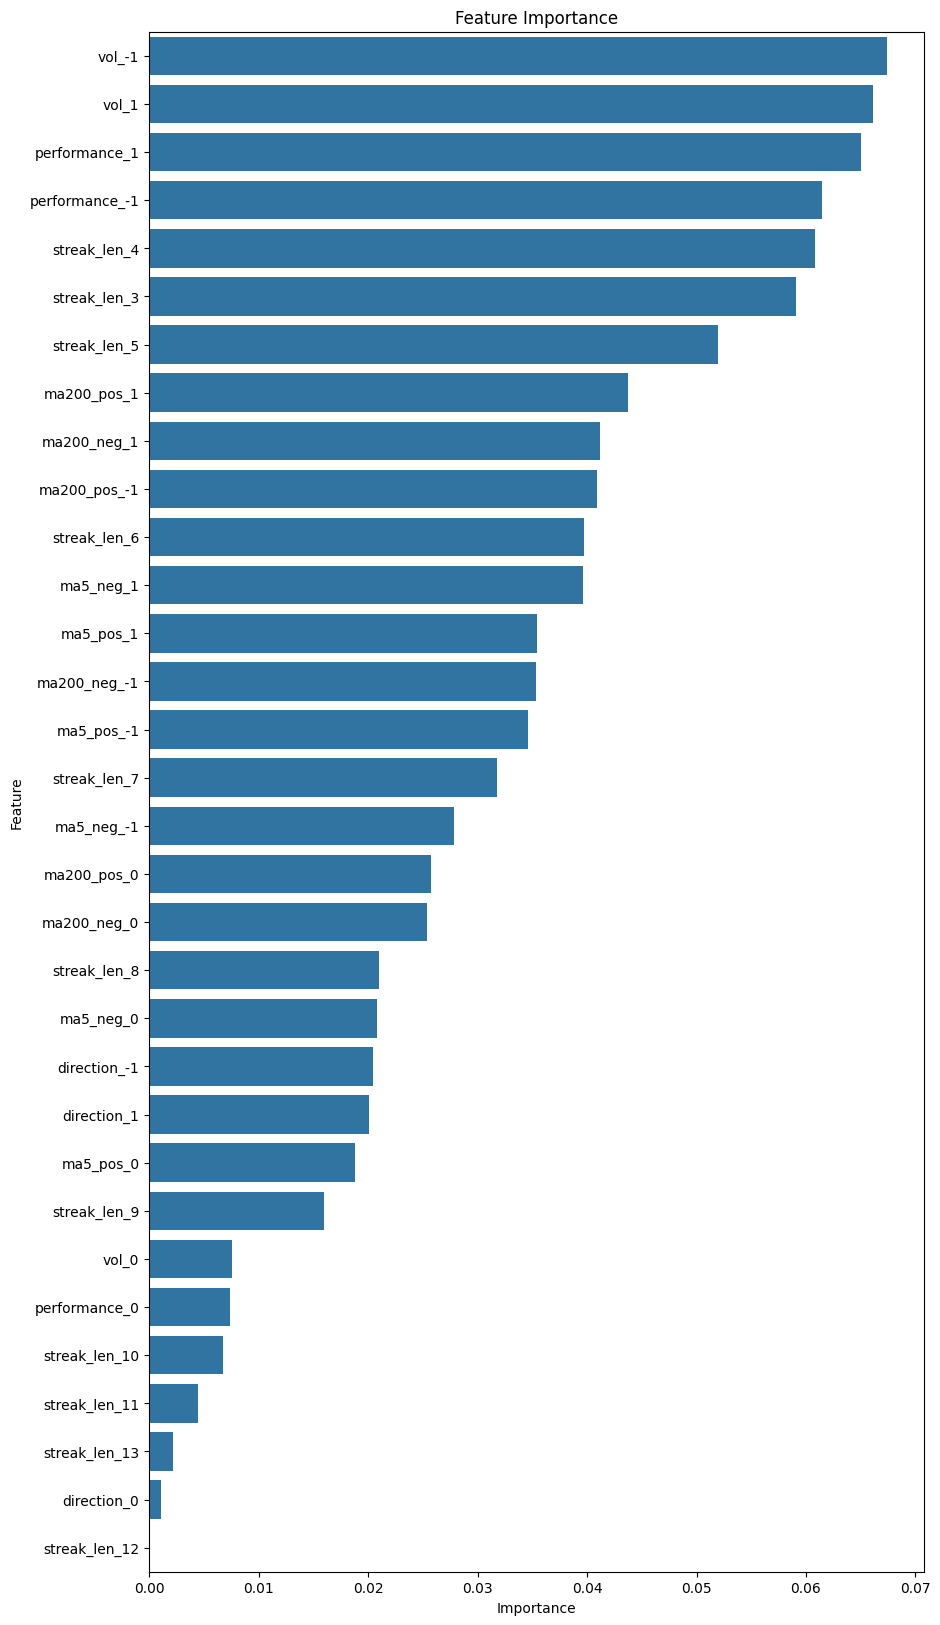

In [29]:
# Plot feature importance
plt.figure(figsize=(10, 20))
sns.barplot(data=importance_df, x='Importance', y='Feature')
plt.title('Feature Importance')
plt.yticks(rotation=0)
plt.show()

### 10. Visualize Decision Trees

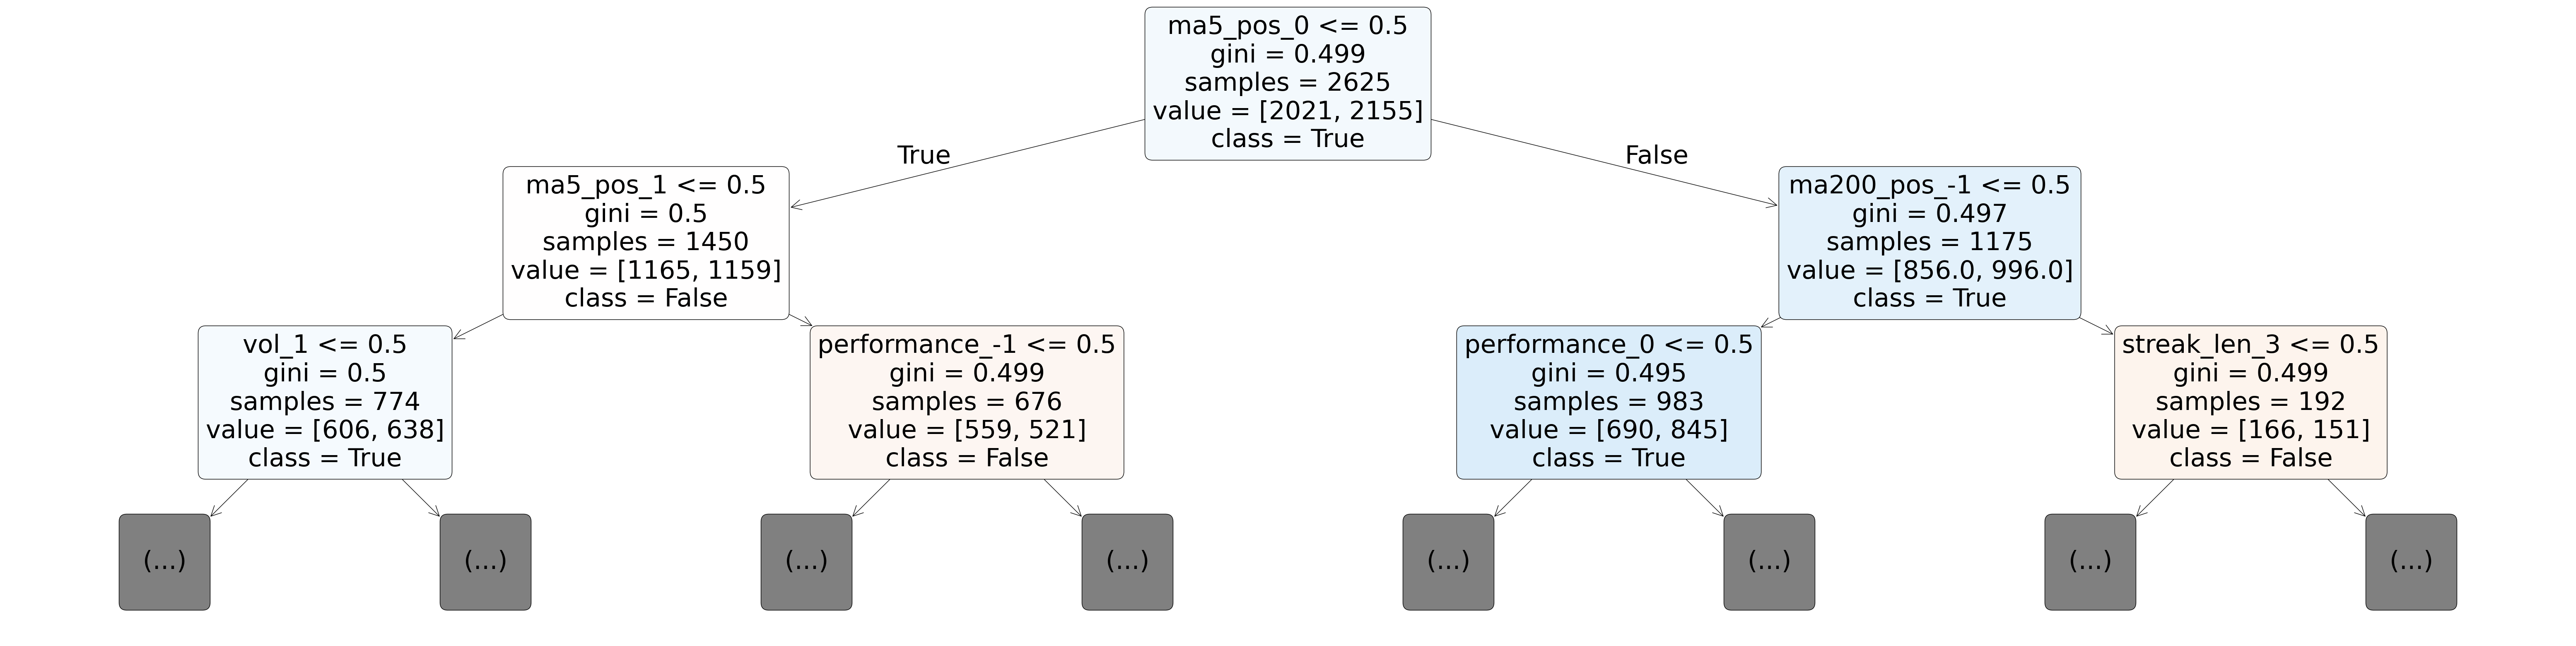

In [30]:
# Visualize one of the decision trees in the Random Forest
plt.figure(figsize=(80, 20))
plot_tree(model.estimators_[0], feature_names=x_train.columns, max_depth=2, filled=True, rounded=True, class_names=[str(cls) for cls in model.classes_])
plt.show()

### 11. Hyperparameter Tuning (Optional)

In [31]:
# Helper function for hyperparameter tuning
def test_params(**params):
    model = RandomForestClassifier(random_state=42, n_jobs=-1, **params).fit(x_train, y_train)
    return model.score(x_train, y_train), model.score(x_test, y_test)

# Example usage
test_params(max_depth=5)

(0.5632183908045977, 0.5205741626794258)

### 12. Save Models

In [32]:
# Save the trained model
joblib.dump(model, 'random_forest_model.pkl')
print("✅ Model saved successfully!")

✅ Model saved successfully!
